In [1]:
# imports
import pandas as pd
import numpy as np
import category_encoders as ce
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
# suppress warning messages
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(r"https://raw.githubusercontent.com/JonathanBechtel/dat-02-22/main/ClassMaterial/Unit3/data/ks2.csv")

In [3]:
# helper functions to aid in the process
def split_data(df, split_frac=0.2, random_state=42):
    df = df.drop(['deadline', 'launched'], axis = 1)
    X  = df.drop('state', axis=1)
    y  = df['state']
    # notice the use of 'stratify' -- makes sure y values are in equal proportions in train + test
    return train_test_split(X, y, test_size = split_frac, stratify = y, random_state = random_state)

# helper function to pull out feature importances_
def get_feature_importances(pipe, X_train, onehot=False):
    if onehot:
        X_train = pipe[0].transform(X_train)
        X_train = pipe[1].transform(X_train)
    return pd.DataFrame({
        'Col': X_train.columns,
        'Importance': pipe[-1].feature_importances_
    }).sort_values(by='Importance', ascending=False)

In [4]:
def get_model_scores(mod, X_train, y_train, X_test, y_test, val_score = True, test_score=False):
    if val_score:
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                          test_size = 0.2, 
                                                          stratify = y_train, 
                                                          random_state= 42)
 
    mod.fit(X_train, y_train)
    
    results = {}
    
    results['train_score'] = mod.score(X_train, y_train)
    if val_score:
        results['val_score'] = mod.score(X_val, y_val)
        
    if test_score:
        results['test_score'] = mod.score(X_test, y_test)
        
    return results

In [5]:
# split data
X_train, X_test, y_train, y_test = split_data(df)

# create pipe and get model score
te   = ce.TargetEncoder(min_samples_leaf = 30)
# setting eval_metric here to avoid a warning message -- does not really change anything though
mod  = XGBClassifier(eval_metric = 'logloss')

pipe = make_pipeline(te, mod)

scores = get_model_scores(pipe, X_train, y_train, X_test, y_test, test_score = True)

# initial scores are closely aligned, will leave test set alone for now
scores

{'train_score': 0.6991522206756928,
 'val_score': 0.6874799655829804,
 'test_score': 0.6884776828494689}

In [9]:
train_idx = X_train.index

In [10]:
train_idx

Int64Index([317618, 181611, 195846,  37117,  95025, 127068,  55623, 312957,
            223810,  20089,
            ...
             92806,  13401,  27823, 178806, 184316, 134725, 106564,  35971,
              6711, 106672],
           dtype='int64', length=296363)

In [14]:
grouping = df.iloc[train_idx].groupby('category')['goal'].mean().reset_index().rename({'goal': 'cat_avg'}, axis = 1)

In [15]:
grouping

,category,cat_avg
0,3D Printing,46466.180661
1,Academic,64565.577500
2,Accessories,13403.480450
3,Action,373074.337457
4,Animals,10290.464145
...,...,...
154,Woodworking,11374.694298
155,Workshops,10007.921221
156,World Music,33424.979016
157,Young Adult,24821.152946


In [21]:
df = df.merge(grouping, on ='category', how = 'left')

In [23]:
df['cat_pct'] = df['goal'] / df['cat_avg']

In [24]:
df.head()

,ID,name,category,main_category,currency,deadline,launched,state,country,goal,cat_avg,cat_pct
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 00:00:00,2015-08-11 12:12:28,0,GB,1533.95,5357.412576,0.286323
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01 00:00:00,2017-09-02 04:43:57,0,US,30000.00,61956.089277,0.484214
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:00:00,2013-01-12 00:20:50,0,US,45000.00,61956.089277,0.726321
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 00:00:00,2012-03-17 03:24:11,0,US,5000.00,23047.711072,0.216941
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 00:00:00,2015-07-04 08:35:03,0,US,19500.00,91834.510688,0.212338


In [25]:
train_idx

Int64Index([317618, 181611, 195846,  37117,  95025, 127068,  55623, 312957,
            223810,  20089,
            ...
             92806,  13401,  27823, 178806, 184316, 134725, 106564,  35971,
              6711, 106672],
           dtype='int64', length=296363)

In [27]:
df.iloc[train_idx]

,ID,name,category,main_category,currency,deadline,launched,state,country,goal,cat_avg,cat_pct
317618,723318017,City Reflections,Photography,Photography,USD,2012-05-31 00:00:00,2012-04-11 15:40:45,0,US,1500.0,10736.366800,0.139712
181611,1944996418,Nothin' To Lose Entertainment Album & Album Re...,Hip-Hop,Music,USD,2013-08-03 00:00:00,2013-07-04 02:49:02,0,US,10000.0,20588.600707,0.485706
195846,2019366381,The Real African History: As It Relates To Th...,Nonfiction,Publishing,USD,2014-09-12 00:00:00,2014-07-14 23:45:23,0,US,100000.0,19051.776030,5.248854
37117,1192319792,Ameritocracy: Card Game,Tabletop Games,Games,USD,2016-05-18 00:00:00,2016-04-15 18:02:56,1,US,12500.0,14717.959924,0.849302
95025,1493261104,$1 + 10K PEOPLE CHALLENGE,Hip-Hop,Music,USD,2015-08-11 00:00:00,2015-07-12 16:24:52,0,US,10000.0,20588.600707,0.485706
...,...,...,...,...,...,...,...,...,...,...,...,...
134725,1699214470,Making a horror movie about finding the Founta...,Film & Video,Film & Video,USD,2012-09-01 00:00:00,2012-08-18 00:02:14,1,US,3300.0,91834.510688,0.035934
106564,1553430656,The Nightingale,Design,Design,DKK,2016-10-24 00:00:00,2016-09-29 08:24:23,0,DK,36709.1,30123.085015,1.218637
35971,1186439102,Double D string stretcher,Music,Music,USD,2016-06-23 00:00:00,2016-05-14 17:12:57,0,US,25000.0,23047.711072,1.084706
6711,1034862045,Visions of Fantastic Realms - Calendar Project,Illustration,Art,USD,2012-01-01 00:00:00,2011-12-14 03:40:58,0,US,5000.0,35343.614746,0.141468


In [30]:
country_grouping = df.iloc[train_idx].groupby('country')['goal'].mean().reset_index().rename({'goal': 'cntry_avg'}, axis = 1)

In [33]:
df = df.merge(country_grouping, on ='country', how = 'left')

In [36]:
df['cntry_pct'] = df['goal'] / df['cntry_avg']

In [37]:
# split data
X_train, X_test, y_train, y_test = split_data(df)

# create pipe and get model score
te   = ce.TargetEncoder(min_samples_leaf = 30)
# setting eval_metric here to avoid a warning message -- does not really change anything though
mod  = XGBClassifier(eval_metric = 'logloss')

pipe = make_pipeline(te, mod)

scores = get_model_scores(pipe, X_train, y_train, X_test, y_test)

# initial scores are closely aligned, will leave test set alone for now
scores

{'train_score': 0.7010755409338226, 'val_score': 0.6885934573920672}

In [38]:
X_train

,ID,name,category,main_category,currency,country,goal,cat_avg,cat_pct,cntry_avg,cntry_pct
317618,723318017,City Reflections,Photography,Photography,USD,US,1500.0,10736.366800,0.139712,42877.290333,0.034984
181611,1944996418,Nothin' To Lose Entertainment Album & Album Re...,Hip-Hop,Music,USD,US,10000.0,20588.600707,0.485706,42877.290333,0.233224
195846,2019366381,The Real African History: As It Relates To Th...,Nonfiction,Publishing,USD,US,100000.0,19051.776030,5.248854,42877.290333,2.332237
37117,1192319792,Ameritocracy: Card Game,Tabletop Games,Games,USD,US,12500.0,14717.959924,0.849302,42877.290333,0.291530
95025,1493261104,$1 + 10K PEOPLE CHALLENGE,Hip-Hop,Music,USD,US,10000.0,20588.600707,0.485706,42877.290333,0.233224
...,...,...,...,...,...,...,...,...,...,...,...
134725,1699214470,Making a horror movie about finding the Founta...,Film & Video,Film & Video,USD,US,3300.0,91834.510688,0.035934,42877.290333,0.076964
106564,1553430656,The Nightingale,Design,Design,DKK,DK,36709.1,30123.085015,1.218637,25087.408737,1.463248
35971,1186439102,Double D string stretcher,Music,Music,USD,US,25000.0,23047.711072,1.084706,42877.290333,0.583059
6711,1034862045,Visions of Fantastic Realms - Calendar Project,Illustration,Art,USD,US,5000.0,35343.614746,0.141468,42877.290333,0.116612


In [39]:
# parameter search
estimators = [100, 200, 300, 400]
max_depth  = [3, 4]
sub_sample = [0.8, 0.6] # this is the amount of samples to randomly sample in each round
learning_rate = [0.1, 0.2]
cv_scores  = []

# do a training loop
for estimator in estimators:
    for depth in max_depth:
        for sample in sub_sample:
            for rate in learning_rate:
                print(f"Fitting new training loop for rounds: {estimator}, depth: {depth}, sampling rate: {sample}, rate: {rate}")
                pipe[-1].set_params(n_estimators = estimator, 
                                    max_depth = depth, 
                                    subsample = sample,
                                    learning_rate = rate)
                scores = get_model_scores(pipe, X_train, y_train, X_test, y_test)
                cv_scores.append((scores['train_score'], scores['val_score'], estimator, depth, sample, rate))

Fitting new training loop for rounds: 100, depth: 3, sampling rate: 0.8, rate: 0.1
Fitting new training loop for rounds: 100, depth: 3, sampling rate: 0.8, rate: 0.2
Fitting new training loop for rounds: 100, depth: 3, sampling rate: 0.6, rate: 0.1
Fitting new training loop for rounds: 100, depth: 3, sampling rate: 0.6, rate: 0.2
Fitting new training loop for rounds: 100, depth: 4, sampling rate: 0.8, rate: 0.1
Fitting new training loop for rounds: 100, depth: 4, sampling rate: 0.8, rate: 0.2
Fitting new training loop for rounds: 100, depth: 4, sampling rate: 0.6, rate: 0.1
Fitting new training loop for rounds: 100, depth: 4, sampling rate: 0.6, rate: 0.2
Fitting new training loop for rounds: 200, depth: 3, sampling rate: 0.8, rate: 0.1
Fitting new training loop for rounds: 200, depth: 3, sampling rate: 0.8, rate: 0.2
Fitting new training loop for rounds: 200, depth: 3, sampling rate: 0.6, rate: 0.1
Fitting new training loop for rounds: 200, depth: 3, sampling rate: 0.6, rate: 0.2
Fitt

In [41]:
max(cv_scores, key = lambda x: x[1])

(0.6932515078662111, 0.6890827189445448, 300, 4, 0.8, 0.1)

In [62]:
ohe = ce.OneHotEncoder(cols = ['category', 'country', 'currency'], use_cat_names = True)
te  = ce.TargetEncoder()

pipe = make_pipeline(ohe, te, mod)

In [63]:
pipe[-1].set_params(n_estimators = 300, max_depth = 4, sub_sample = 0.8, learning_rate = 0.1)

[20:40:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=12,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, sub_sample=0.8, subsample=0.6,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [43]:
X_train

,ID,name,category,main_category,currency,country,goal,cat_avg,cat_pct,cntry_avg,cntry_pct
317618,723318017,City Reflections,Photography,Photography,USD,US,1500.0,10736.366800,0.139712,42877.290333,0.034984
181611,1944996418,Nothin' To Lose Entertainment Album & Album Re...,Hip-Hop,Music,USD,US,10000.0,20588.600707,0.485706,42877.290333,0.233224
195846,2019366381,The Real African History: As It Relates To Th...,Nonfiction,Publishing,USD,US,100000.0,19051.776030,5.248854,42877.290333,2.332237
37117,1192319792,Ameritocracy: Card Game,Tabletop Games,Games,USD,US,12500.0,14717.959924,0.849302,42877.290333,0.291530
95025,1493261104,$1 + 10K PEOPLE CHALLENGE,Hip-Hop,Music,USD,US,10000.0,20588.600707,0.485706,42877.290333,0.233224
...,...,...,...,...,...,...,...,...,...,...,...
134725,1699214470,Making a horror movie about finding the Founta...,Film & Video,Film & Video,USD,US,3300.0,91834.510688,0.035934,42877.290333,0.076964
106564,1553430656,The Nightingale,Design,Design,DKK,DK,36709.1,30123.085015,1.218637,25087.408737,1.463248
35971,1186439102,Double D string stretcher,Music,Music,USD,US,25000.0,23047.711072,1.084706,42877.290333,0.583059
6711,1034862045,Visions of Fantastic Realms - Calendar Project,Illustration,Art,USD,US,5000.0,35343.614746,0.141468,42877.290333,0.116612


In [67]:
X_train

,ID,name,category,main_category,currency,country,goal,cat_avg,cat_pct,cntry_avg,cntry_pct
317618,723318017,City Reflections,Photography,Photography,USD,US,1500.0,10736.366800,0.139712,42877.290333,0.034984
181611,1944996418,Nothin' To Lose Entertainment Album & Album Re...,Hip-Hop,Music,USD,US,10000.0,20588.600707,0.485706,42877.290333,0.233224
195846,2019366381,The Real African History: As It Relates To Th...,Nonfiction,Publishing,USD,US,100000.0,19051.776030,5.248854,42877.290333,2.332237
37117,1192319792,Ameritocracy: Card Game,Tabletop Games,Games,USD,US,12500.0,14717.959924,0.849302,42877.290333,0.291530
95025,1493261104,$1 + 10K PEOPLE CHALLENGE,Hip-Hop,Music,USD,US,10000.0,20588.600707,0.485706,42877.290333,0.233224
...,...,...,...,...,...,...,...,...,...,...,...
134725,1699214470,Making a horror movie about finding the Founta...,Film & Video,Film & Video,USD,US,3300.0,91834.510688,0.035934,42877.290333,0.076964
106564,1553430656,The Nightingale,Design,Design,DKK,DK,36709.1,30123.085015,1.218637,25087.408737,1.463248
35971,1186439102,Double D string stretcher,Music,Music,USD,US,25000.0,23047.711072,1.084706,42877.290333,0.583059
6711,1034862045,Visions of Fantastic Realms - Calendar Project,Illustration,Art,USD,US,5000.0,35343.614746,0.141468,42877.290333,0.116612


In [70]:
# split data
X_train, X_test, y_train, y_test = split_data(df)

In [48]:
feats = get_feature_importances(pipe, X_train)

In [49]:
feats

,Col,Importance
2,category,0.446267
6,goal,0.212451
5,country,0.084010
8,cat_pct,0.065387
4,currency,0.045536
10,cntry_pct,0.034895
3,main_category,0.034765
7,cat_avg,0.023340
9,cntry_avg,0.019744
0,ID,0.017103


In [50]:
pipe.predict(X_train)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [51]:
pipe.predict_proba(X_train)

array([[0.6257547 , 0.3742453 ],
       [0.8909044 , 0.1090956 ],
       [0.9528683 , 0.04713174],
       ...,
       [0.6684269 , 0.33157313],
       [0.5708511 , 0.4291489 ],
       [0.51922834, 0.48077163]], dtype=float32)

In [53]:
from pdpbox import pdp, info_plots

# go ahead and transform X_train to prep it for PDPBox
# the model is already fitted so we don't have to worry about doing that
X_train = pipe[0].transform(X_train)

In [72]:
dir(pdp_day_of_week)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_type',
 'count_data',
 'display_columns',
 'feature',
 'feature_grids',
 'feature_type',
 'hist_data',
 'ice_lines',
 'n_classes',
 'pdp',
 'percentile_info',
 'which_class']

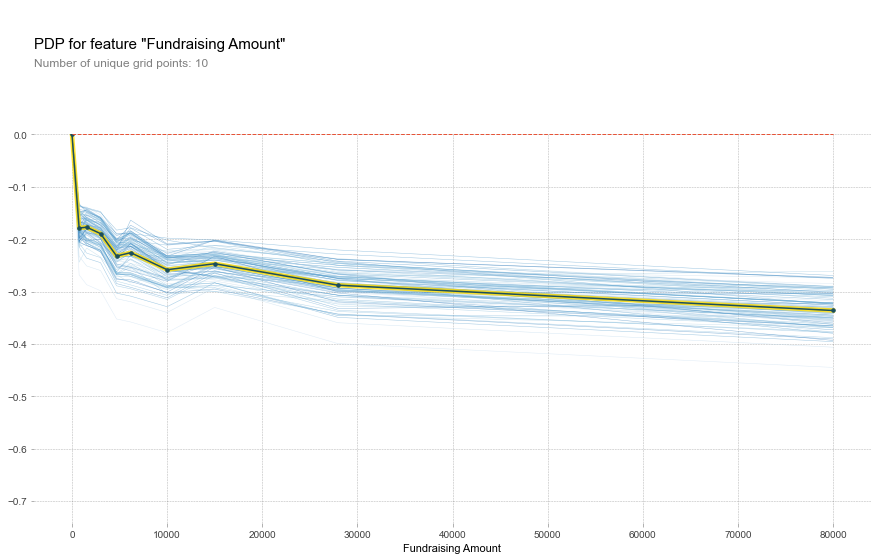

In [54]:
# what was the additive impact of different values of goal?  What was its marginal impact?
pdp_day_of_week = pdp.pdp_isolate(
    model=pipe[-1], 
    dataset=X_train[X_train['goal'] < X_train['goal'].quantile(.95)], # filtering out unusually large values
    model_features=X_train.columns.tolist(), 
    feature='goal',
)

fig, axes = pdp.pdp_plot(pdp_day_of_week, 'Fundraising Amount', plot_lines=True, frac_to_plot=100)